## Sử dụng tập dữ liệu comment_data với thu thập được từ tiki.vn để phân tích và phân loại cảm xúc (clustering sentiment) bằng mô hình KNN

Mục tiêu:
- Accuracy > 85%
- Precision > 70%

## 1. Tiền xử lý dữ liệu

### a. Cài đặt những thư viện cần thiết

In [1]:
!pip install underthesea
!pip install wordcloud
!pip install imblearn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import string
from underthesea import word_tokenize
from underthesea import text_normalize
import nltk
import wordcloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

### b. Đọc dữ liệu

In [5]:
df = pd.read_csv('/content/comments_data.csv')
df.head()

,id,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at
0,NaN,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09
1,NaN,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09
2,NaN,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09
3,NaN,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09
4,NaN,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,0,15223358,1,1743002964,Pham Ngoc Huyen,1.742183e+09


In [6]:
df.shape

(34808, 9)

#### Nhận xét:
- Dữ liệu bao gồm ~35.000 dòng với 8 cột chính bao gồm:
  + title: Tiêu đề comment của khách hàng
  + content: Nội dung comment của khách hàng
  + thank_count: Số phẩn hồi tích cực về comment đó
  + customer_id: id của khách hàng đã comment
  + rating: số sao mà khách hàng đánh giá về sản phẩm (1-5 sao)
  + created_at: Ngày comment
  + customer_name: Tên của khách hàng
  + purchased_at: Ngày mua hàng


#### Cấu trúc của tập dữ liệu

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34808 entries, 0 to 34807
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             0 non-null      float64
 1   title          34808 non-null  object 
 2   content        18329 non-null  object 
 3   thank_count    34808 non-null  int64  
 4   customer_id    34808 non-null  int64  
 5   rating         34808 non-null  int64  
 6   created_at     34808 non-null  int64  
 7   customer_name  34790 non-null  object 
 8   purchased_at   34802 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 2.4+ MB


Đầu tiên, xoá cột id là cột rỗng, không có giá trị

In [8]:
df.drop(['id'], axis=1, inplace=True)

In [9]:
df.describe()

,thank_count,customer_id,rating,created_at,purchased_at
count,34808.000000,3.480800e+04,34808.000000,3.480800e+04,3.480200e+04
mean,0.339922,1.248825e+07,4.546196,1.678761e+09,1.676434e+09
std,3.078819,8.728273e+06,1.038707,3.951077e+07,3.922055e+07
min,0.000000,2.700000e+01,1.000000,1.412468e+09,1.400236e+09
25%,0.000000,6.053798e+06,5.000000,1.651545e+09,1.649996e+09
50%,0.000000,1.128167e+07,5.000000,1.677936e+09,1.675608e+09
75%,0.000000,1.913384e+07,5.000000,1.710921e+09,1.708489e+09
max,193.000000,3.037014e+07,5.000000,1.746623e+09,1.746542e+09


#### Chuyển ngày mua thành dạng date_time

In [10]:
df['purchased_date'] = pd.to_datetime(df['purchased_at'], unit='s')

# Tùy chọn: hiển thị theo định dạng dd/mm/yyyy
df['purchased_date'] = df['purchased_date'].dt.strftime('%d/%m/%Y')
df

,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at,purchased_date
0,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09,19/03/2025
1,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09,17/03/2025
2,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,0,30287322,5,1742634561,Hoàng Minh,1.742396e+09,19/03/2025
3,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",0,30327032,5,1742385565,Mai Dũng,1.742204e+09,17/03/2025
4,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,0,15223358,1,1743002964,Pham Ngoc Huyen,1.742183e+09,17/03/2025
...,...,...,...,...,...,...,...,...,...
34803,Cực kì hài lòng,NaN,0,246797,5,1669132765,Nguyễn Quốc Minh Thức,1.668920e+09,20/11/2022
34804,Hài lòng,NaN,0,2174894,4,1665290129,Lê Trung Tuyến,1.665247e+09,08/10/2022
34805,Cực kì hài lòng,NaN,0,15983903,5,1656743750,Gia Bảo,1.656735e+09,02/07/2022
34806,Cực kì hài lòng,NaN,0,19655996,5,1653655694,Minh Phúc,1.652790e+09,17/05/2022


Xoá luôn 2 cột purchased_at và thank_count do không dùng đến

In [11]:
df.drop(['purchased_at', 'thank_count'], axis=1, inplace=True)

In [12]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='s').dt.strftime('%d/%m/%Y')

In [13]:
df.head()

,title,content,customer_id,rating,created_at,customer_name,purchased_date
0,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,30287322,5,22/03/2025,Hoàng Minh,19/03/2025
1,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",30327032,5,19/03/2025,Mai Dũng,17/03/2025
2,Cực kì hài lòng,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,30287322,5,22/03/2025,Hoàng Minh,19/03/2025
3,Cực kì hài lòng,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",30327032,5,19/03/2025,Mai Dũng,17/03/2025
4,Rất không hài lòng,Airpods mới dùng đã hư. Chính sách bảo hành lò...,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025


### C. Xoá lặp

In [14]:
 df = df.drop_duplicates()

### D. Kiểm tra dữ liệu null

In [15]:
df.isnull().sum()

,0
title,0
content,14008
customer_id,0
rating,0
created_at,0
customer_name,16
purchased_date,6


In [16]:
# df = df.dropna()

### Có thể thấy cột content thiếu rất nhiều, ta sẽ cân nhắc có nên sử dụng cột title để fill vào cột này không. Nguyên tắc phải đảm bảo cảm xúc phải tương đương, ví dụ: 'title' == Cực kì hài lòng	=> rating = 5

Kiểm tra các giá trị ở trong cột title

In [17]:
df[df['content'].isnull()][['title', 'rating']].value_counts()

,,count
title,rating,
Cực kì hài lòng,5,12204
Hài lòng,4,1752
Bình thường,3,24
Hài lòng,5,19
Cực kì hài lòng,4,6
Rất không hài lòng,1,2
Không hài lòng,2,1


có thể thấy title khá tương ứng với rating mà người dùng đã đánh giá, suy ra có thể sử dụng cột title

### Sau khi cân nhắc nhằm đảm bảo tính phong phú của comment, tiến hành sử dụng dữ liệu từ cột content trước. Sau đó sẽ xem xét

So sánh ưu nhược điểm của việc train với dữ liệu gộp và dữ liệu chỉ có cột content:
- Ưu điểm: Tận dụng được lượng dữ liệu lớn ~ 35.000 Từ để train
- Nhược điểm: Một vài từ xuất hiện nhiều như "hài lòng", "cực kì" có thể ảnh hưởng xấu đến việc đánh giá feedback của khách hàng. Có thể dẫn đến việc overfiting hoặc đánh giá không khách quan.
#### Cho nên với bài toán này, mình quyết định chỉ sử dụng dữ liệu ở cột content, chấp nhận việc sẽ mất hơn 14.000 DÒNG dữ liệu

In [18]:
df = df.dropna()

In [19]:
def combine_title_content(row):
    if pd.isna(row['content']) or row['content'].strip() == "":
        return ""  # Nếu content rỗng hoặc NaN, trả về chuỗi rỗng
    else:
        return row['content']  # Chỉ trả về nội dung từ cột 'content'

df['full_text'] = df.apply(combine_title_content, axis=1)

<ipython-input-19-f35cf5e73ae6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df.apply(combine_title_content, axis=1)


sau khi gộp thành cột full_text, ta tiến hành xoá 2 cột title và content vì:
- Đã trích xuất tất cả thông tin cần thiết từ 2 cột này
- Nhằm giảm nhiễu khi huấn luyện mô hình

In [20]:
df.drop(['title', 'content'], axis=1, inplace=True)
df.head()

<ipython-input-20-eb5074477cfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['title', 'content'], axis=1, inplace=True)


,customer_id,rating,created_at,customer_name,purchased_date,full_text
0,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...
1,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng..."
4,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...
5,15532413,5,05/04/2025,Gia Khương Trương,03/04/2025,"Giao hàng rất nhanh, đúng hẹn, sản phẩm mới xà..."
6,8726469,5,11/11/2024,Nguyen Tan Loc,10/11/2024,"Good chính hãng,xài ngon lành nha mọi người"


Tiếp theo, ta tiến hành làm sạch văn bản với các bước:
- Chuyển văn bản thành chữ thường
- Xoá tất cả emoji
- Giảm các kí tự lặp lại (ví dụ: "aaaabbb" = "ab")
- Đảm bảo khoảng trắng trước và sau dấu câu
- Giảm các khoảng trắng liên tiếp
...

In [21]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

def clean_text(text):
    text = text.lower() # lowercase text

    text = re.sub(emoji_pattern, " ", text) # remove emojis

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    return text

#### kiểm tra lại

In [22]:
df['corpus'] = df['full_text'].map(lambda text: clean_text(text))
df.head(20)

,customer_id,rating,created_at,customer_name,purchased_date,full_text,corpus
0,30287322,5,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...
1,30327032,5,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...
4,15223358,1,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...,airpods mới dùng đã hư chính_sách bảo_hành lòn...
5,15532413,5,05/04/2025,Gia Khương Trương,03/04/2025,"Giao hàng rất nhanh, đúng hẹn, sản phẩm mới xà...",giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...
6,8726469,5,11/11/2024,Nguyen Tan Loc,10/11/2024,"Good chính hãng,xài ngon lành nha mọi người",god chính hãng xài ngon_lành_nha mọi người
7,8702212,1,26/03/2025,Phi Hoang Diep,25/03/2025,Sản phẩm mua ngày 26/3/2025 mà hạn bảo hành có...,sản_phẩm mua ngày 26 3 2025 mà hạn bảo_hành có...
8,16473324,5,13/12/2024,lam nguyen,13/12/2024,Hàng còn nguyên seal. Luôn an tâm mua của tiki...,hàng còn nguyên_seal luôn an_tâm mua của tiki ...
9,746760,5,12/12/2024,Quốc Hùng,12/12/2024,Product’s very good!!! Excellent sound quality...,product’s very god excelent sound quality efec...
10,776469,5,12/11/2024,Tran Huu Vinh,11/11/2024,Chất lượng không có gì bàn cải. Chống ồn tốt (...,chất_lượng không có gì bàn cải_chống ồn tốt th...
11,29535252,5,30/03/2025,Vũ Khánh,28/03/2025,Giao hàng rất nhanh. Sản phẩm đóng gói cẩn thận.,giao hàng rất nhanh sản_phẩm đóng_gói cẩn_thận


#### Tạo nhãn cho các comment: 1,2 sao = 0; 3 sao = 1, 4,5 sao = 2;

In [23]:
def get_label(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

# Tạo cột mới 'label' trong DataFrame
df['label'] = df['rating'].apply(get_label)
df.drop(['rating'], axis=1, inplace=True)
df.head()

,customer_id,created_at,customer_name,purchased_date,full_text,corpus,label
0,30287322,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
1,30327032,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...,2
4,15223358,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...,airpods mới dùng đã hư chính_sách bảo_hành lòn...,0
5,15532413,05/04/2025,Gia Khương Trương,03/04/2025,"Giao hàng rất nhanh, đúng hẹn, sản phẩm mới xà...",giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...,2
6,8726469,11/11/2024,Nguyen Tan Loc,10/11/2024,"Good chính hãng,xài ngon lành nha mọi người",god chính hãng xài ngon_lành_nha mọi người,2


Kiểm tra 15 từ xuất hiện nhiều nhất trong văn bản

Number of words: 12534
Most common words: [('ok', 473), ('tốt', 285), ('god', 96), ('sản_phẩm tốt', 51), ('rất tốt', 50), ('đẹp', 45), ('chất_lượng tốt', 34), ('ngon', 32), ('giao hàng nhanh', 31), ('ổn', 31), ('hàng tốt', 30), ('tuyệt_vời', 28), ('hài_lòng', 27), ('sản_phẩm ok', 26), ('rất hài_lòng', 24)]


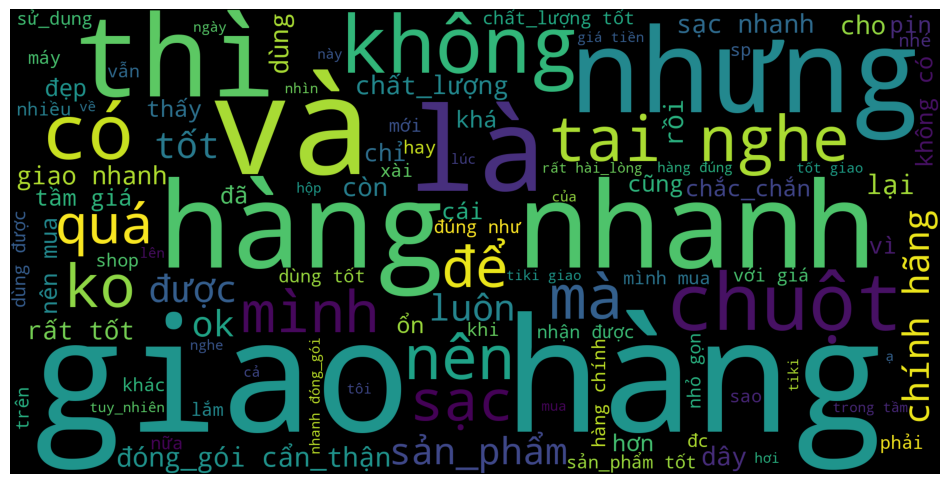

In [24]:
all_words = [token for token in df['corpus'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

In [25]:
df.isnull().sum()

,0
customer_id,0
created_at,0
customer_name,0
purchased_date,0
full_text,0
corpus,0
label,0


#### Nhận xét: Dữ liệu đang bị mất cân bằng nặng nề khi số lượng đánh giá tích cực có số lượng  lớn (>80%) trong tập dữ liệu. Điều này được cho là phổ biến đối với những sản phẩm có mức đánh giá trung bình ở mức cao (>4 sao)

Kiểm tra lại kích thước của dữ liệu

In [26]:
df.head()

,customer_id,created_at,customer_name,purchased_date,full_text,corpus,label
0,30287322,22/03/2025,Hoàng Minh,19/03/2025,Hàng giao siêu nhanh đóng gói chỉn chu ko móp ...,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
1,30327032,19/03/2025,Mai Dũng,17/03/2025,"Nghe rất đã, mic hút, hàng chính hãng nên cũng...",nghe rất đã mic hút hàng chính hãng nên cũng y...,2
4,15223358,26/03/2025,Pham Ngoc Huyen,17/03/2025,Airpods mới dùng đã hư. Chính sách bảo hành lò...,airpods mới dùng đã hư chính_sách bảo_hành lòn...,0
5,15532413,05/04/2025,Gia Khương Trương,03/04/2025,"Giao hàng rất nhanh, đúng hẹn, sản phẩm mới xà...",giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...,2
6,8726469,11/11/2024,Nguyen Tan Loc,10/11/2024,"Good chính hãng,xài ngon lành nha mọi người",god chính hãng xài ngon_lành_nha mọi người,2


Xoá cột full_text để tiện xử lý

In [27]:
df.drop(['full_text'], axis=1, inplace=True)

In [28]:
df.shape

(14519, 6)

In [29]:
df.head()

,customer_id,created_at,customer_name,purchased_date,corpus,label
0,30287322,22/03/2025,Hoàng Minh,19/03/2025,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
1,30327032,19/03/2025,Mai Dũng,17/03/2025,nghe rất đã mic hút hàng chính hãng nên cũng y...,2
4,15223358,26/03/2025,Pham Ngoc Huyen,17/03/2025,airpods mới dùng đã hư chính_sách bảo_hành lòn...,0
5,15532413,05/04/2025,Gia Khương Trương,03/04/2025,giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...,2
6,8726469,11/11/2024,Nguyen Tan Loc,10/11/2024,god chính hãng xài ngon_lành_nha mọi người,2


### D.Data Visualization

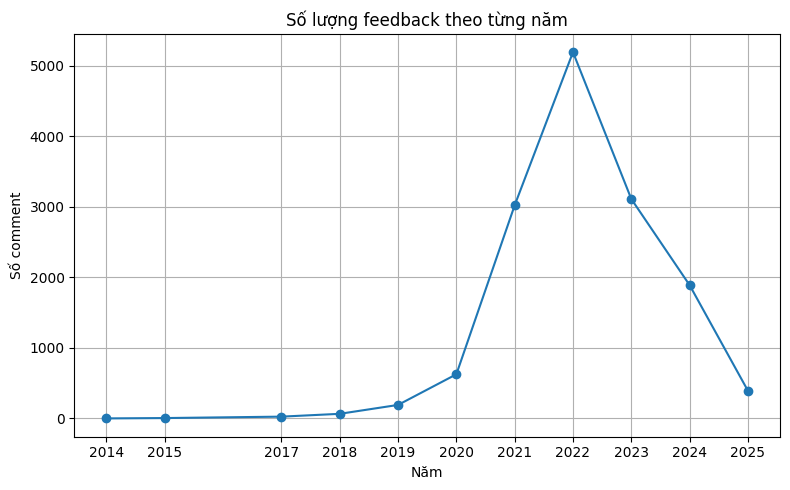

In [30]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['created_at'])
df['year'] = df['created_at'].dt.year
yearly_comment_count = df.groupby('year').size().reset_index(name='comment_count')

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(yearly_comment_count['year'], yearly_comment_count['comment_count'], marker='o')
plt.title('Số lượng feedback theo từng năm')
plt.xlabel('Năm')
plt.ylabel('Số comment')
plt.grid(True)
plt.xticks(yearly_comment_count['year'])
plt.tight_layout()
plt.show()


Có thể thấy số lượng feedback của khách hàng chủ yếu từ năm 2019 cho tới nay, đỉnh điểm là năm 2022, Điều này là dễ hiểu do 2021-2022 là đỉnh điểm của đại dịch Covid_19. Mọi người sẽ có xu hướng mua hàng trên mạng nhiều hơn

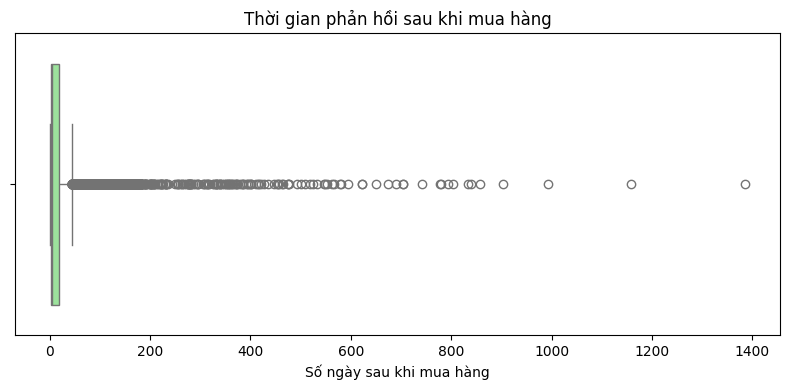

In [31]:

# Ép kiểu datetime cho hai cột ngày
df['created_at'] = pd.to_datetime(df['created_at'], format='%d/%m/%Y', errors='coerce')
df['purchased_date'] = pd.to_datetime(df['purchased_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['created_at', 'purchased_date'])
df['days_between'] = (df['created_at'] - df['purchased_date']).dt.days
df = df[df['days_between'] >= 0]
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['days_between'], color='lightgreen')
plt.title('Thời gian phản hồi sau khi mua hàng')
plt.xlabel('Số ngày sau khi mua hàng')
plt.tight_layout()
plt.show()



Có thể thấy phần đông khách hàng phản hồi sau khi mua từ 0-400 ngày. Sau đó thưa dần. Để đảm bảo khách quan, ta tiến hành loại bỏ những feedback phản hồi sau 800 ngày

In [32]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%d/%m/%Y', errors='coerce')
df['purchased_date'] = pd.to_datetime(df['purchased_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['created_at', 'purchased_date'])
df['days_between'] = (df['created_at'] - df['purchased_date']).dt.days
df = df[(df['days_between'] >= 0) & (df['days_between'] <= 800)]
df.drop(['days_between', 'year',], axis=1, inplace=True)
df.head()

,customer_id,created_at,customer_name,purchased_date,corpus,label
0,30287322,2025-03-22,Hoàng Minh,2025-03-19,hàng giao_siêu nhanh đóng_gói chỉn chu_ko móp_...,2
1,30327032,2025-03-19,Mai Dũng,2025-03-17,nghe rất đã mic hút hàng chính hãng nên cũng y...,2
4,15223358,2025-03-26,Pham Ngoc Huyen,2025-03-17,airpods mới dùng đã hư chính_sách bảo_hành lòn...,0
5,15532413,2025-04-05,Gia Khương Trương,2025-04-03,giao hàng rất nhanh đúng hẹn sản_phẩm mới xài ...,2
6,8726469,2024-11-11,Nguyen Tan Loc,2024-11-10,god chính hãng xài ngon_lành_nha mọi người,2


In [33]:
df.shape

(14407, 6)

Dữ liệu còn lại hơn 14.000 dòng với 6 cột

### E. Chia dữ liệu train, test

In [34]:
df['corpus'] = df['corpus'].astype(str)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df['corpus'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [36]:
X_train.shape

(11525,)

In [37]:
X_train

,corpus
8271,hàng chuẩn_thanks mua hàng tiki an_tâm hàng ch...
27237,ốp rất ok nhé
23162,mua 2 cái mà giao thiếu 1 dây sạc và 1 núm tai...
6300,đóng_gói kỷ_sản_phẩm rất hài_lòng sản_phẩm đún...
34402,sản phẫn tốt giá hiwjp ls
...,...
26934,giao hàng đúng hẹn được check hàng trước khi n...
15230,kiểu_dáng đẹp màu đẹp chuột mượt click êm
20538,tuyệt_vời
24332,tp link chưa bao_giờ làm mình thất_vọng cắm ph...


In [38]:
train_df = pd.DataFrame({'corpus': X_train, 'label': y_train})
train_df.to_csv('train_df.csv', index=False)
test_df = pd.DataFrame({'corpus': X_test, 'label': y_test})
test_df.to_csv('test_df.csv', index=False)

### F. Kiểm tra phân phối của các nhãn ở trong tập dữ liệu

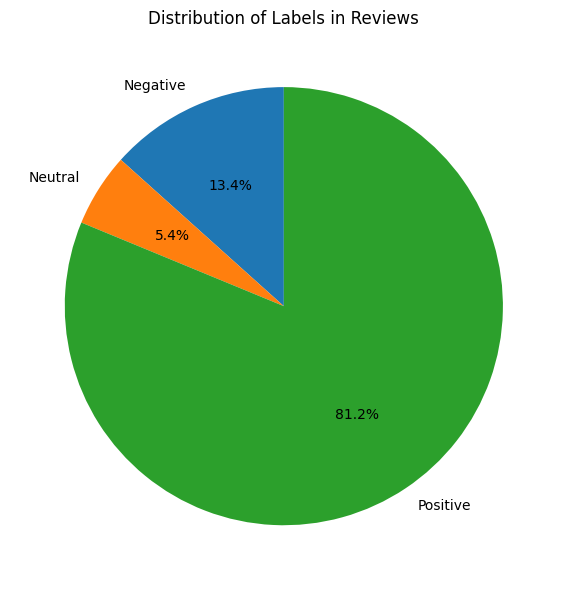

In [39]:
# Count the occurrences of each label
label_counts = df['label'].value_counts().sort_index()

# Pie chart cho labels
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
fig, ax = plt.subplots(figsize=(6, 6))  # chỉ tạo 1 biểu đồ
ax.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Labels in Reviews')

plt.tight_layout()
plt.show()

### G. Over sampling đối với tập dữ liệu train

In [40]:
train_df = pd.DataFrame({'corpus': X_train, 'label': y_train})

df_0 = train_df[train_df['label'] == 0]
df_1 = train_df[train_df['label'] == 1]
df_2 = train_df[train_df['label'] == 2]

target_samples = int(0.5 * len(df_2))

df_0_upsampled = resample(df_0,
                          replace=True,
                          n_samples=target_samples,
                          random_state=42)

df_1_upsampled = resample(df_1,
                          replace=True,
                          n_samples=target_samples,
                          random_state=42)

train_balanced = pd.concat([df_0_upsampled, df_1_upsampled, df_2])

train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Tách lại X_train, y_train
X_train_balanced = train_balanced['corpus']
y_train_balanced = train_balanced['label']

#### Kiểm tra kích thước của các nhãn sau khi over sampling

In [41]:
unique_labels, counts = np.unique(y_train_balanced, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 4681
Label 1: 4681
Label 2: 9362


#### Vẽ lại biểu đồ phân phối của các nhãn

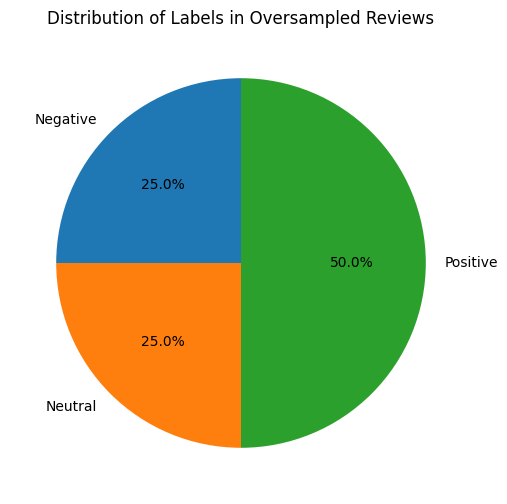

In [42]:
label_counts_oversampled = pd.Series(y_train_balanced).value_counts().sort_index()
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(6, 6))
plt.pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels in Oversampled Reviews')
plt.show()

### H.Text vectorizer

Loại bỏ một số từ vô nghĩa

In [43]:
# Initialize the CountVectorizer
stop_words_vi = ['và', 'của', 'là', 'trong', 'có', 'với', 'là', 'theo']

vectorizer = CountVectorizer(max_features=5000, stop_words=stop_words_vi)


X_train_vec = vectorizer.fit_transform(X_train_balanced)
X_test_vec = vectorizer.transform(X_test)

### I.Sử dụng K-Fold để tìm ra tham số đẹp nhất

In [ ]:
knn_model = KNeighborsClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_neighbors': [2, 3, 4],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Sử dụng GridSearchCV để tìm tham số tốt nhất
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=kf, scoring='f1_macro')

# Huấn luyện và tìm tham số tối ưu
grid_search.fit(X_train_vec, y_train_balanced)

# In ra kết quả tìm kiếm tốt nhất
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.9576


## 2. Huấn luyện mô hình KNN

In [44]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn.fit(X_train_vec, y_train_balanced)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

Xuất mô hình để tiện áp dụng cho những mô hình sau

In [45]:
import joblib

joblib.dump(knn, 'KNeighborsClassifier.pkl')

['KNeighborsClassifier.pkl']

In [46]:
y_pred = knn.predict(X_test_vec)

#### Đánh giá mô hình thông qua 4 chỉ số: Accuracy, F1 Score, Recall, Precision

In [47]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.8092
F1 Score: 0.4523
Recall: 0.4334
Precision: 0.4990


#### Ma trận nhầm lẫn

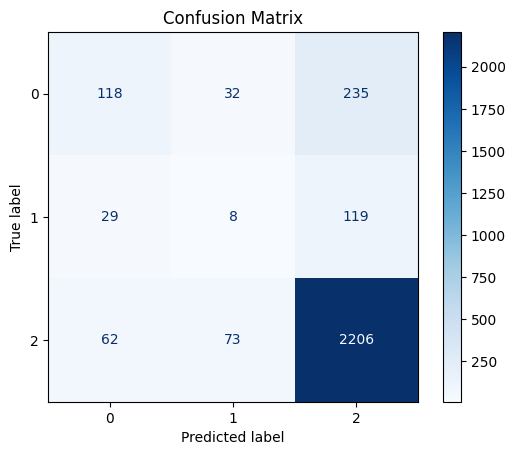

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels = [0, 1, 2])

# Hiển thị
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [49]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.8092
F1 Score: 0.4523
Recall: 0.4334
Precision: 0.4990


### Nhận xét:

#### Nhìn chung mô hình này cho thấy hiệu suất không đồng đều giữa các lớp, với hiệu suất vượt trội ở lớp 2 nhưng gặp khó khăn trong việc phân loại chính xác các mẫu thuộc lớp 0 và lớp 1

- Nguyên nhân: Dữ liệu bị mất cân bẳng với những mẫu thuộc lớp 0 và 1

#### Định hướng khắc phục và cải tiến:
- Thu thập thêm dữ liệu vê 2 nhãn còn lại nhằm giải quyết vấn đề mất cân bằng dữ liệu.
- Thử nghiệm nhằm chọn mô hình phù hợp hơn, có khả năng dự đoán tốt hơn

- Cảm ơn anh/chị đã đọc hết
- Vũ minh thuận - 0382330924 - vuminhthuan.work@gmail.com